# Lesson 1: Linear regression with times series

## Example 0: Book sales

In [3]:
import pandas as pd

df = pd.read_csv(
    "data/book_sales.csv",
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)

df.head()

,Hardcover
Date,
2000-04-01,139
2000-04-02,128
2000-04-03,172
2000-04-04,139
2000-04-05,191


### define time dummy 

In [20]:
import numpy as np

df['Time'] = np.arange(len(df.index))

df.head()

,Hardcover,Lag_1,Time
Date,,,
2000-04-01,139,NaN,0
2000-04-02,128,139.0,1
2000-04-03,172,128.0,2
2000-04-04,139,172.0,3
2000-04-05,191,139.0,4


### Plot
observe that using the *regplot* option in seaborn gives us the linear regression straight away (does it also do the numbers or only graphycally?)

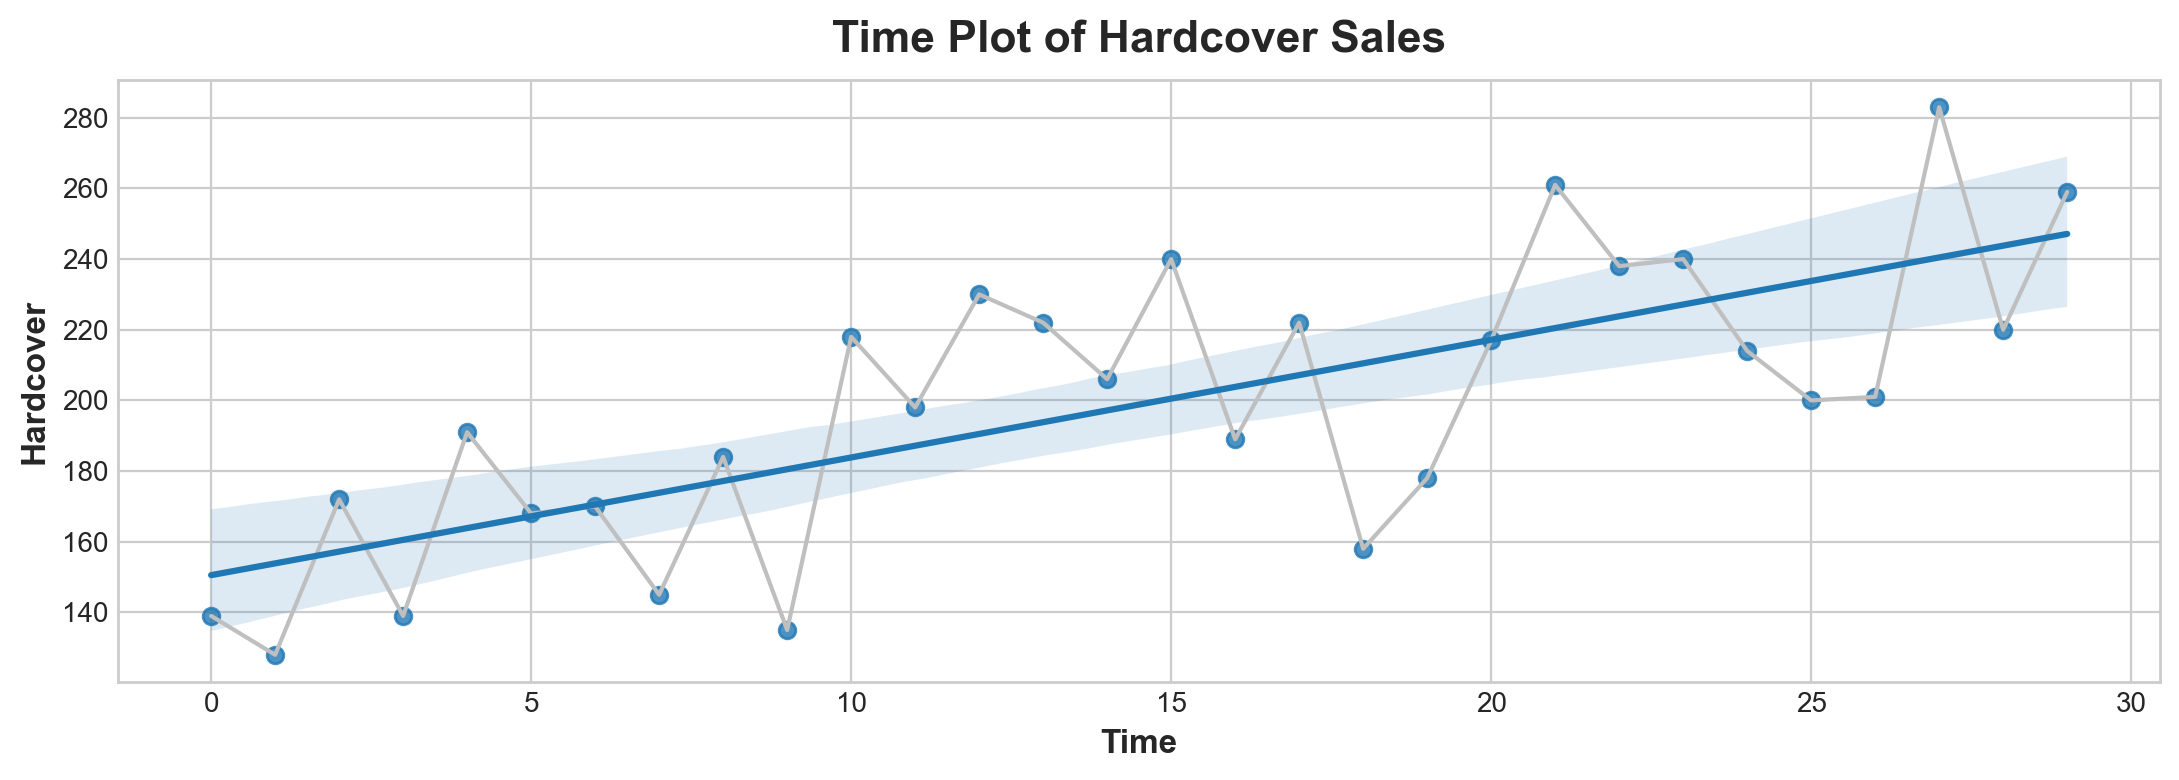

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use("seaborn-whitegrid")  ### RGA This is deprecated
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=df
                 #, ci=None
                 #, scatter_kws=dict(color='0.25')
                 )

ax.set_title('Time Plot of Hardcover Sales');

### Introduce lag to make correlations manifest

In [17]:
df['Lag_1'] = df['Hardcover'].shift(1)
df = df.reindex(columns=['Hardcover', 'Lag_1'])

df.head()

,Hardcover,Lag_1
Date,,
2000-04-01,139,NaN
2000-04-02,128,139.0
2000-04-03,172,128.0
2000-04-04,139,172.0
2000-04-05,191,139.0


The correlation should now be obvious (from a scatter plot)

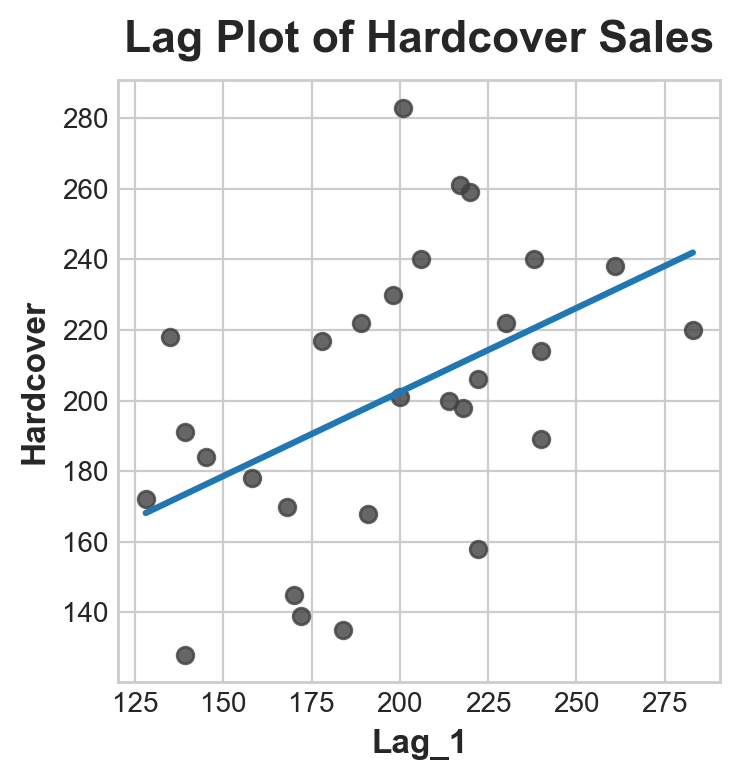

In [23]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='Hardcover', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');

## Example 1: Tunnel traffic

In [29]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
##plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
data_dir = Path("data")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])

# Create a time series in Pandas by setting the index to a date
# column. We parsed "Day" as a date type by using `parse_dates` when
# loading the data.
tunnel = tunnel.set_index("Day")

# By default, Pandas creates a `DatetimeIndex` with dtype `Timestamp`
# (equivalent to `np.datetime64`, representing a time series as a
# sequence of measurements taken at single moments. A `PeriodIndex`,
# on the other hand, represents a time series as a sequence of
# quantities accumulated over periods of time. Periods are often
# easier to work with, so that's what we'll use in this course.
tunnel = tunnel.to_period()

tunnel.head(len(tunnel))

,NumVehicles
Day,
2003-11-01,103536
2003-11-02,92051
2003-11-03,100795
2003-11-04,102352
2003-11-05,106569
...,...
2005-11-12,104646
2005-11-13,94424
2005-11-14,112165


In [31]:
df = tunnel.copy()

df['Time'] = np.arange(len(tunnel.index)) ## RGA this is assuming there are no missing dates

df.head()

,NumVehicles,Time
Day,,
2003-11-01,103536,0
2003-11-02,92051,1
2003-11-03,100795,2
2003-11-04,102352,3
2003-11-05,106569,4


### Fit a linear regression to the tunnel data

In [32]:
from sklearn.linear_model import LinearRegression

# Training data
X = df.loc[:, ['Time']]  # features
y = df.loc[:, 'NumVehicles']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

RGA: Kaggle actually says "The model actually created is (approximately): Vehicles = 22.5 * Time + 98176" -> how do I find this equation!??

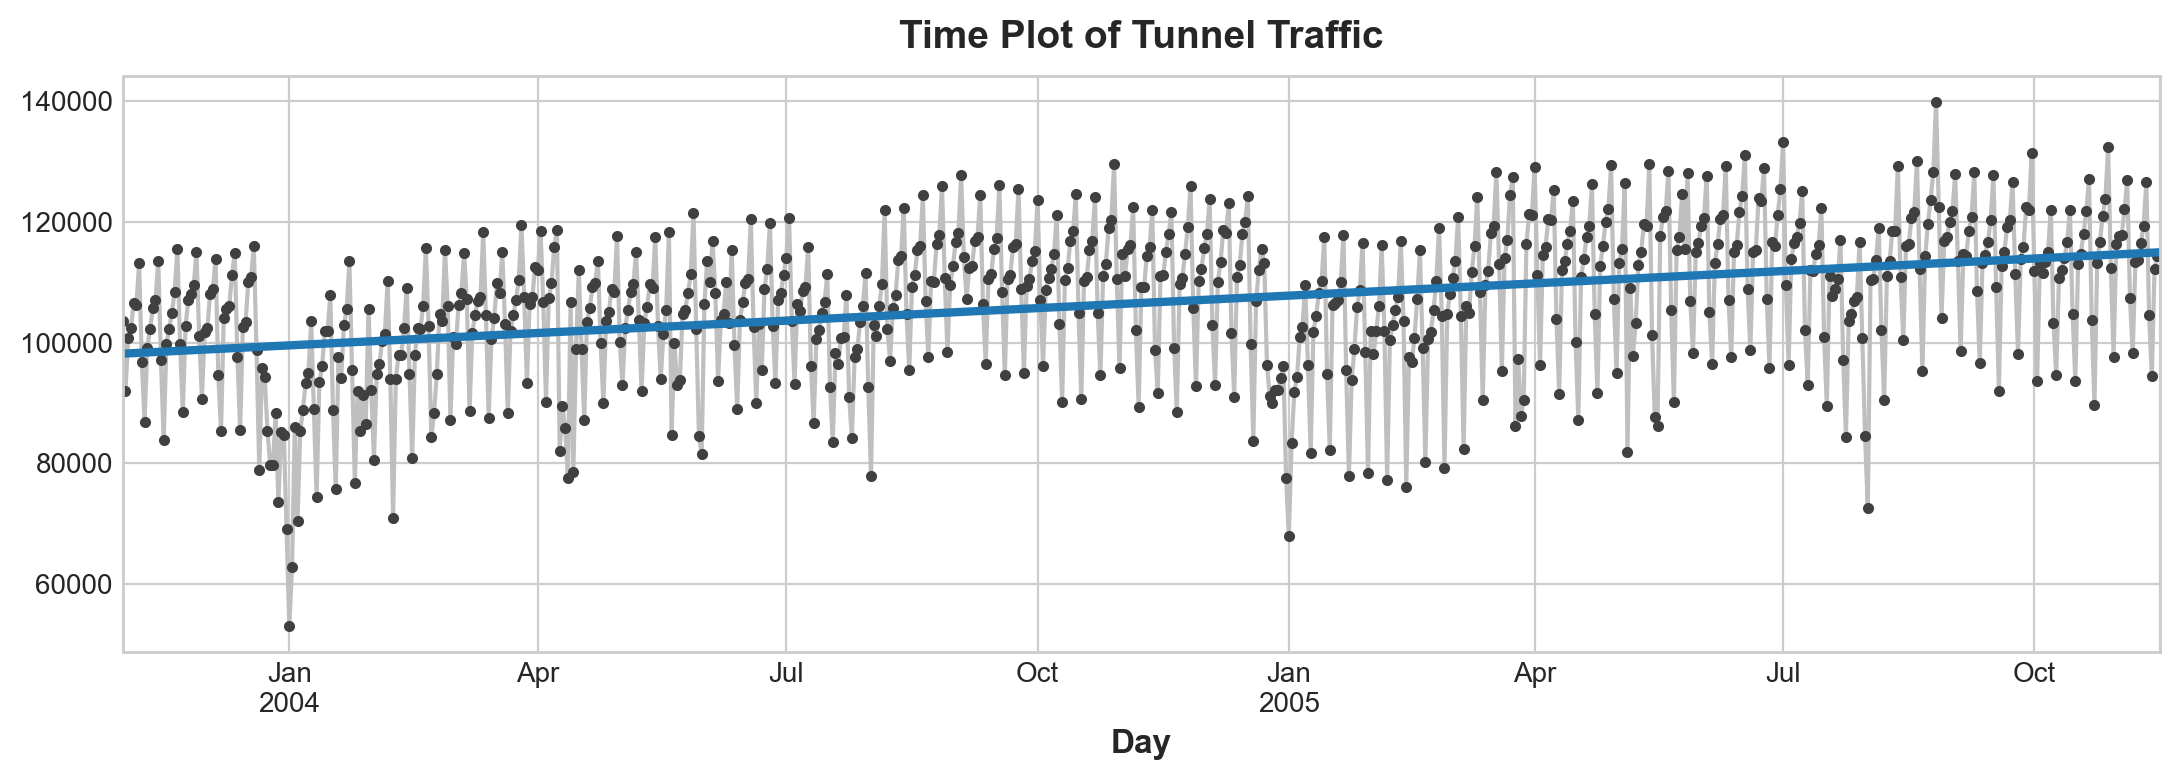

In [33]:
ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic');

extract the lag using *shift* and repeat the prediction using that feature instead of the time dummy

In [34]:
df['Lag_1'] = df['NumVehicles'].shift(1)
df.head()

,NumVehicles,Time,Lag_1
Day,,,
2003-11-01,103536,0,NaN
2003-11-02,92051,1,103536.0
2003-11-03,100795,2,92051.0
2003-11-04,102352,3,100795.0
2003-11-05,106569,4,102352.0


In [36]:
from sklearn.linear_model import LinearRegression

X = df.loc[:, ['Lag_1']]
X.dropna(inplace=True)  # drop missing values in the feature set
y = df.loc[:, 'NumVehicles']  # create the target
y, X = y.align(X, join='inner')  # drop corresponding values in target

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

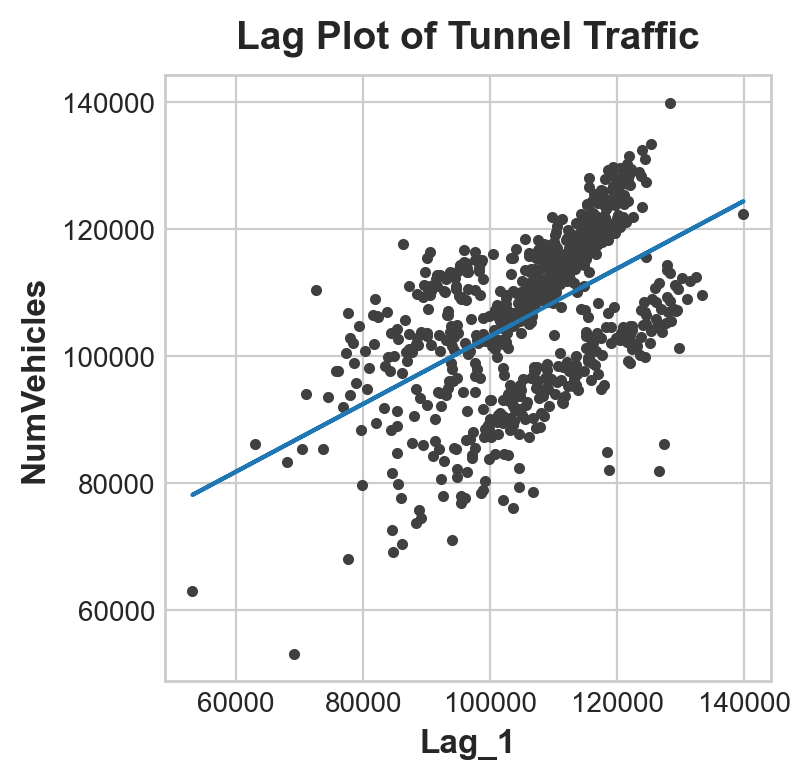

In [37]:
fig, ax = plt.subplots()
ax.plot(X['Lag_1'], y, '.', color='0.25')
ax.plot(X['Lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('NumVehicles')
ax.set_xlabel('Lag_1')
ax.set_title('Lag Plot of Tunnel Traffic');

Check our model on past data

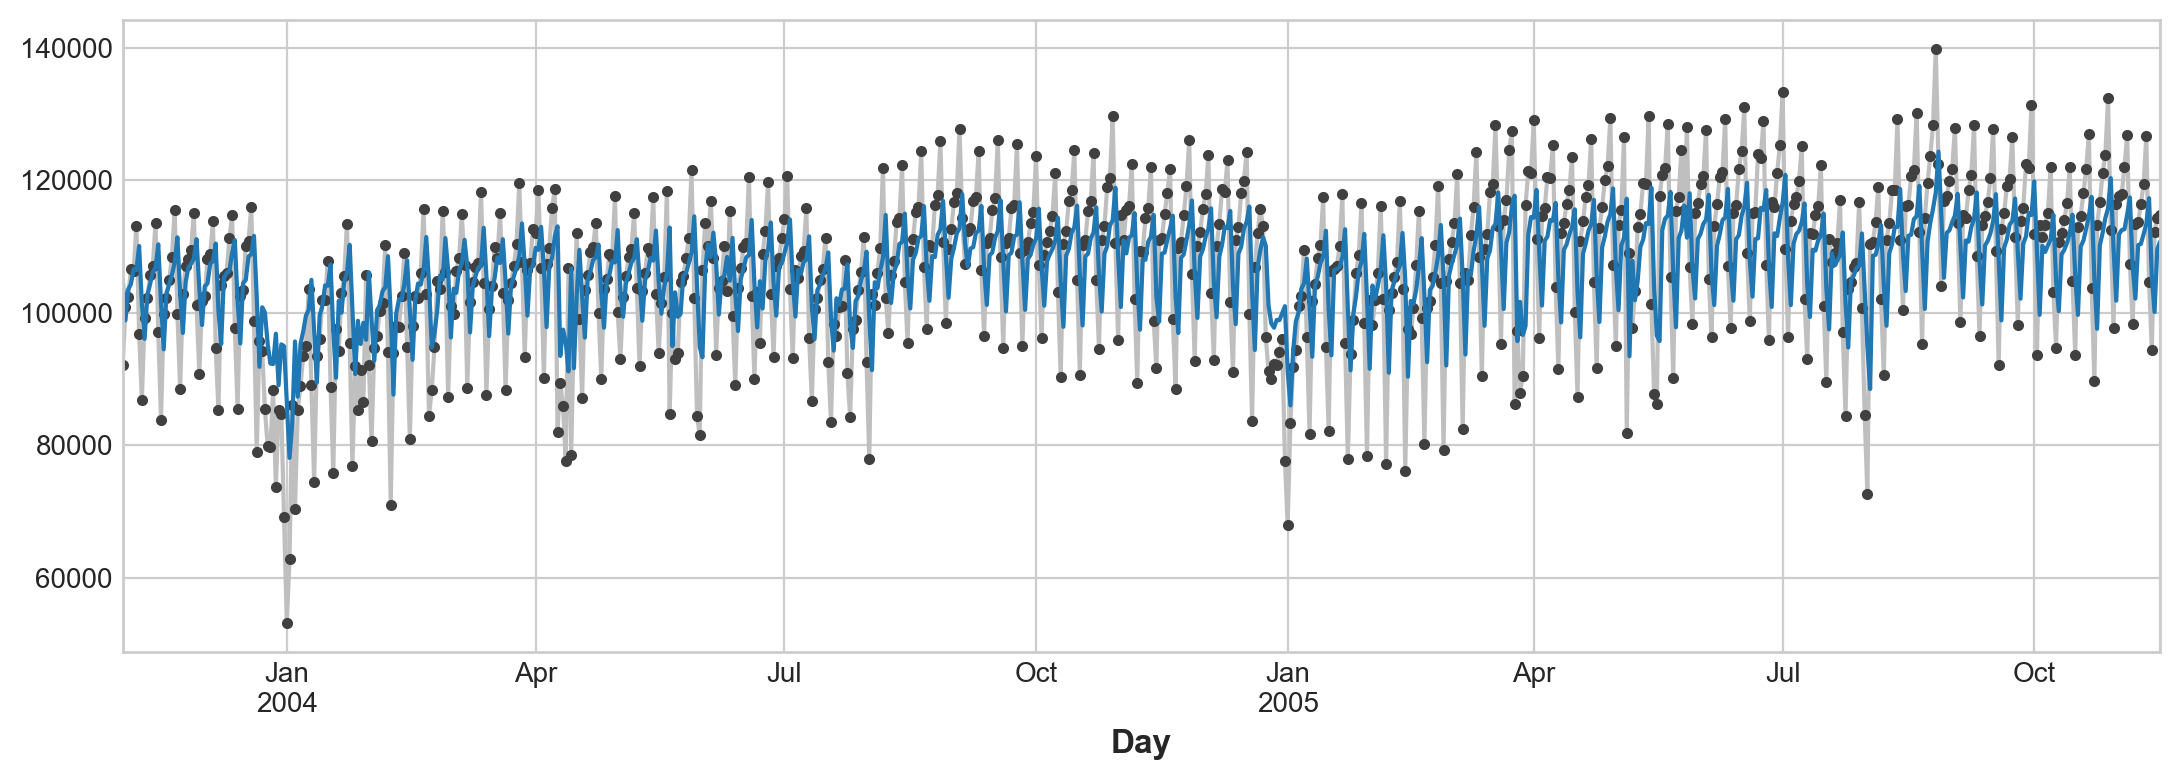

In [38]:
ax = y.plot(**plot_params)
ax = y_pred.plot()

RGA: to do: compare the prediction on top of the real data for both the fit with the lag feature and the fit with the time dummy